# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# Описание данных

Данные находятся в трёх файлах:
* gold_recovery_train.csv — обучающая выборка Скачать датасет;
* gold_recovery_test.csv — тестовая выборка Скачать датасет;
* gold_recovery_full.csv — исходные данные Скачать датасет.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

#  Содержание проекта

<a href='#step1'>1.Подготовка данных</a>
* Импорт библиотек
* Загрузка датасетов
* Очистка данных
* Предобработка данных

<a href='#step2'>2.Анализ данных</a>
* Расмотрение концентрации металлов (Au, Ag, Pb)
* Распределение размеров гранул сырья 
* Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

<a href='#step3'>3.Модель</a>
* Вычисление итоговой sMAPE
* Обучение различных модели и оценка их качества кросс-валидацией
* Вывод



# 1. Подготовка данных <a id='step1'></a>

Импортируем необходимы для проекта библиотеки

Установим последнюю версию scikit learn

In [1]:
pip install -U scikit-learn --user

Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (0.23.2)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

Загружаем необходимые датасеты

In [3]:
full = pd.read_csv('/datasets/gold_recovery_full.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
train = pd.read_csv('/datasets/gold_recovery_train.csv')

Проверка эффективности обогащения

In [4]:
def effectivity(col):
    C = col['rougher.output.concentrate_au']
    F=col['rougher.input.feed_au']
    T=col['rougher.output.tail_au']
    try:
        recovery = (C*(F-T))/(F*(C-T))*100
        return recovery
    except:
        return np.nan

Удаляем пропуски

In [5]:
train_clean = train.dropna()

In [6]:
effectivity(train_clean).describe()

count    11017.000000
mean        82.741888
std         13.590523
min         -0.000000
25%         79.997468
50%         84.847754
75%         89.635149
max        100.000000
dtype: float64

In [7]:
train_clean['rougher.output.recovery'].describe()

count    11017.000000
mean        82.741888
std         13.590523
min          0.000000
25%         79.997468
50%         84.847754
75%         89.635149
max        100.000000
Name: rougher.output.recovery, dtype: float64

Расчитаем отклонение ошибки между расчетным и имеющимся значениями эффективности обогащения

In [8]:
print('MAE =', mean_absolute_error(effectivity(train_clean), train_clean['rougher.output.recovery']))

MAE = 9.555596961987514e-15


Отклонение ошибки минимальное имеющимся данным эффективности обогащения можно доверять.

Анализ признаков, недоступных в тестовой выборке

In [9]:
set(train.columns)-set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Эти данные относятся уже к еще не определенным параметрам относящимся к технологическим процессам и немогут находиться в тестовой выборке. В тестовой выборке могут находиться только те параметры которые определены на старте и не изменяються во время технологическиго процесса.

Признаки с итоговыми данными или выходными характеристиками продуктов на каждом технологическом процессе.

Проведем предобработку данных

Осуществим генерацию функции заполнения пропусков

Используем при заполении пропусков KNNImputer

In [10]:
imputer = KNNImputer()

In [11]:
full.loc[:, full.columns != 'date'] = imputer.fit_transform(full.loc[:, full.columns != 'date'])

In [12]:
train.loc[:, train.columns != 'date'] = imputer.fit_transform(train.loc[:, train.columns != 'date'])

In [13]:
test.loc[:, test.columns != 'date'] = imputer.fit_transform(test.loc[:, test.columns != 'date'])

# 2. Анализ данных <a id='step2'></a>

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

Сформируем словарь элементов

In [14]:
elements = {'au': 'au',
          'ag': 'ag',
           'pb': 'pb'}

Подготовим цикл для формирования диаграмм размаха концентраций элементов Au, Ag, Pb на различных этапах очистки

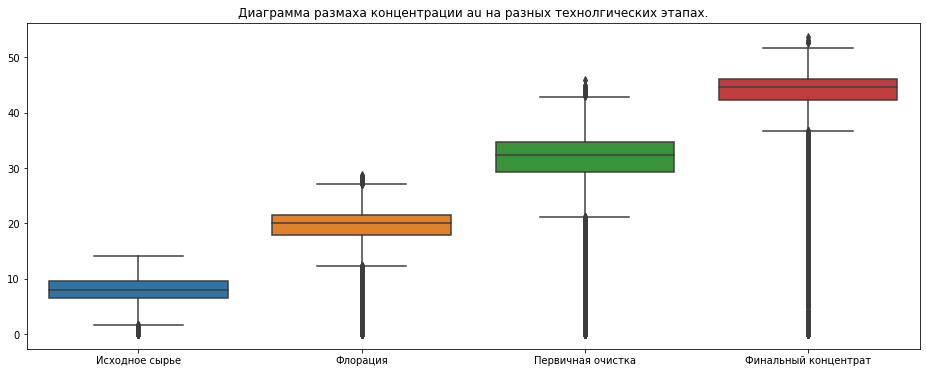

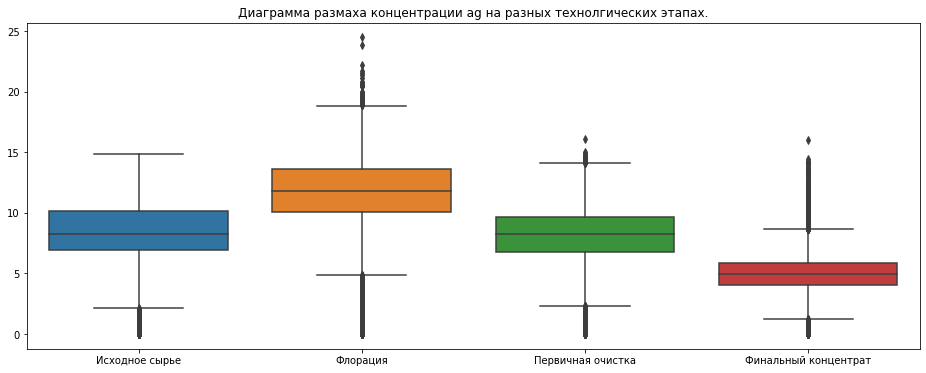

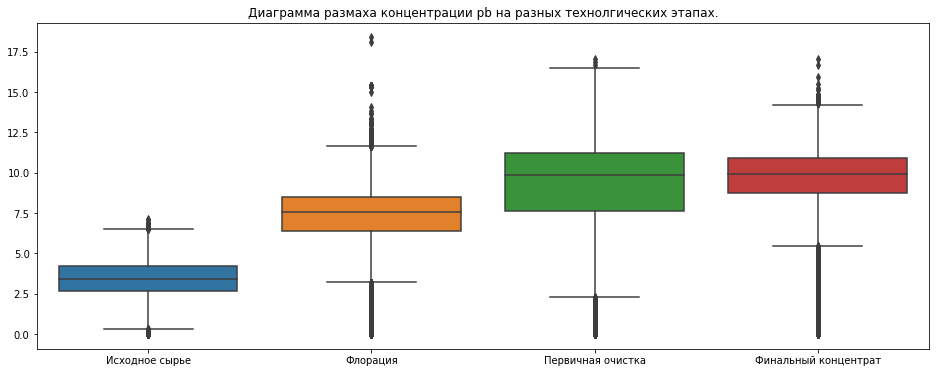

In [15]:
for key in elements.keys(): 
    plt.figure(figsize=(16,6))
    plt.title('Диаграмма размаха концентрации {} на разных технолгических этапах.'.format(elements[key]))
    sns.boxplot(data=full[['rougher.input.feed_' + elements[key],
                           'rougher.output.concentrate_' + elements[key], 
                           'primary_cleaner.output.concentrate_'+ elements[key], 
                           'final.output.concentrate_' + elements[key],]])
    plt.xticks([0,1,2,3], ['Исходное сырье', 'Флорация', 'Первичная очистка', 'Финальный концентрат'])
plt.show()

Концентрация золота растет, серебра падает, а концентрация свинца незначительно возрасла на флорации и стабильна на первичной очистке и финале.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

График распределения размеров гранул перед флорацией

Text(0.5, 1.0, 'График распределения размеров гранул перед флорацией')

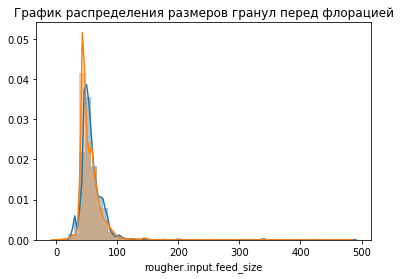

In [16]:
sns.distplot(train['rougher.input.feed_size']) 
sns.distplot(test['rougher.input.feed_size'])
plt.title("График распределения размеров гранул перед флорацией")

График распределения размеров гранул в финальном концентрате

Text(0.5, 1.0, 'График распределения размеров гранул в финальном концентрате')

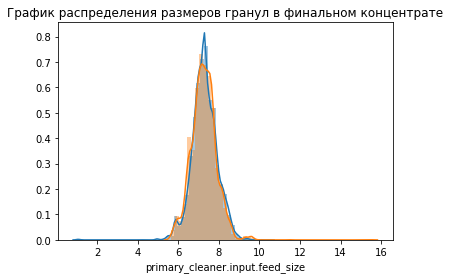

In [17]:
sns.distplot(train['primary_cleaner.input.feed_size'])
sns.distplot(test['primary_cleaner.input.feed_size'])
plt.title("График распределения размеров гранул в финальном концентрате")

Распределения размеров гранул сырья перед флорацией и в финальном концентрате в тестовой и тренировочной выборках практически не отличаются. Оценка моделей будет адекватной.

Исследуем суммарную концентрацию всех веществ на разных стадиях

Функция фильтрации аномалий

In [18]:
def filter_outliers(df, column_name, remove_outliers=False):
    df_column = df[column_name]
    quartile_1 = df_column.describe()['25%']
    quartile_3 = df_column.describe()['75%']
    interquartile_range = quartile_3 - quartile_1
    upper_whisker = quartile_1 + 1.5 * interquartile_range
    lower_whisker = max(quartile_1 - 1.5 * interquartile_range, df_column.min())
    outliers = df[(df_column < lower_whisker) | (df_column > upper_whisker) |
                 (df_column.isnull())]
    if remove_outliers:
        df.drop(outliers.index, inplace=True)

Тренировочкая выборка. Поиск аномалий и фильтрация.

In [19]:
train['rougher.input.feed_sum'] = train['rougher.input.feed_ag'] + train['rougher.input.feed_pb'] + train['rougher.input.feed_sol'] + train['rougher.input.feed_au']

In [20]:
train['final.output.concentrate_sum'] = train['final.output.concentrate_ag'] + train['final.output.concentrate_pb'] + train['final.output.concentrate_sol'] + train['final.output.concentrate_au']
train['rougher.output.concentrate_sum'] = train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_pb'] + train['rougher.output.concentrate_sol'] + train['rougher.output.concentrate_au']

Диаграмм размаха суммарной концентрации на разных тех процессах на тренировочной выборке

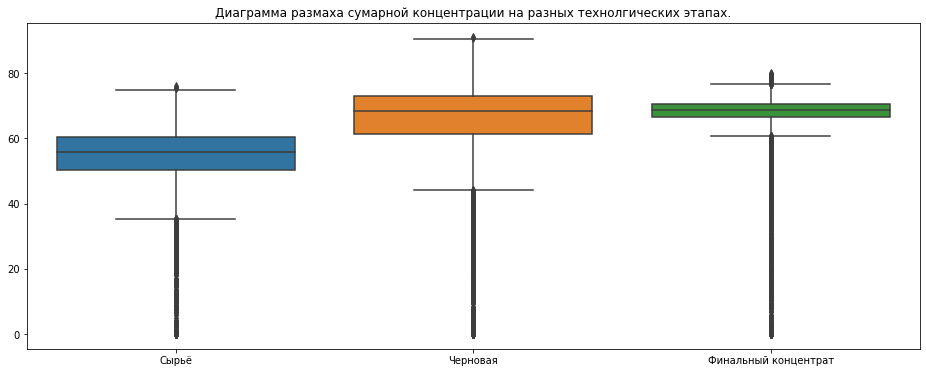

In [21]:
plt.figure(figsize=(16,6)) 
plt.title('Диаграмма размаха сумарной концентрации на разных технолгических этапах.')
sns.boxplot(data=train[['rougher.input.feed_sum','rougher.output.concentrate_sum', 'final.output.concentrate_sum']])
plt.xticks([0,1,2], ['Сырьё','Черновая','Финальный концентрат'])
plt.show()

Фильтрация выбросов

In [22]:
columns = ['rougher.input.feed_sum','rougher.output.concentrate_sum','final.output.concentrate_sum']
for column_name in columns:
    filter_outliers(train, column_name, remove_outliers=True)

In [23]:
num_rows_before = train.shape[0]

Формирование диаграмм размаха суммарных концентрация по тех процессам

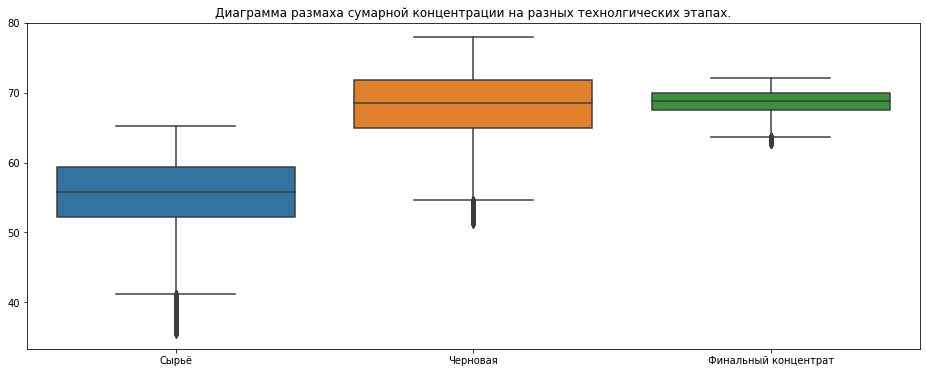

In [24]:
plt.figure(figsize=(16,6))
plt.title('Диаграмма размаха сумарной концентрации на разных технолгических этапах.')
sns.boxplot(data=train[['rougher.input.feed_sum','rougher.output.concentrate_sum', 'final.output.concentrate_sum']])
plt.xticks([0,1,2], ['Сырьё','Черновая','Финальный концентрат'])
plt.show()

Сбросим значений для сохранения целосности данных тренировочной выборки

In [25]:
train = train.drop(['rougher.input.feed_sum','final.output.concentrate_sum','rougher.output.concentrate_sum'], axis=1)

Тестовая выборка. Поиск аномалий и фильтрация.

In [26]:
test['rougher.input.feed_sum'] = test['rougher.input.feed_ag'] + test['rougher.input.feed_pb'] + test['rougher.input.feed_sol'] + test['rougher.input.feed_au']

Диаграммы размаха и поиск выбросов

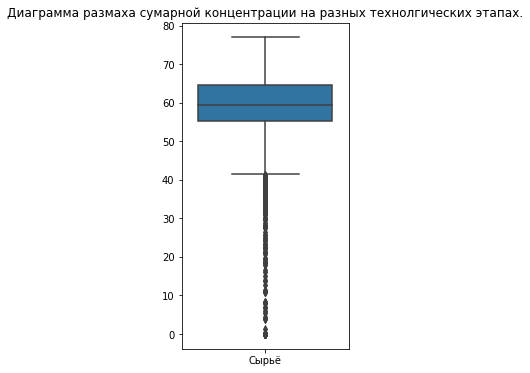

In [27]:
plt.figure(figsize=(3,6))
plt.title('Диаграмма размаха сумарной концентрации на разных технолгических этапах.')
sns.boxplot(data=test[['rougher.input.feed_sum']])
plt.xticks([0], ['Сырьё'])
plt.show()

Отфильтруем выбросы и аномалий

In [28]:
filter_outliers(test, 'rougher.input.feed_sum', remove_outliers=True)

In [29]:
num_rows_before = test.shape[0]

Проверим результат фильтрации

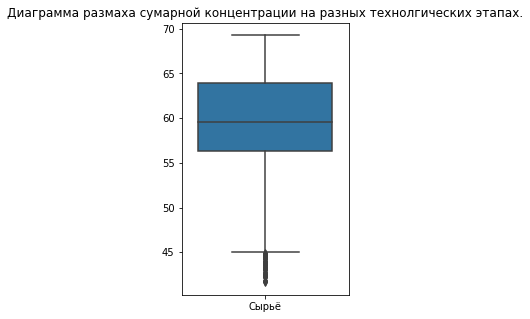

In [30]:
plt.figure(figsize=(3,5))
plt.title('Диаграмма размаха сумарной концентрации на разных технолгических этапах.')
sns.boxplot(data=test[['rougher.input.feed_sum']])
plt.xticks([0], ['Сырьё'])
plt.show()

In [31]:
test = test.drop(['rougher.input.feed_sum'], axis=1)

Сбросим значений для сохранения целосности данных трестовой выборки

# 3. Модель <a id='step3'></a>

Напишим функцию для вычисления итоговой sMAPE.

In [32]:
def smape_end(target_rougher, predict_rougher, target_final, predict_final):
    smape_rougher = 100/len(target_rougher) * np.sum(2 * np.abs(predict_rougher - target_rougher) / 
                                                     (np.abs(target_rougher) + np.abs(predict_rougher)))
    smape_final = 100/len(target_final) * np.sum(2 * np.abs(predict_final - target_final) / 
                                                 (np.abs(target_final) + np.abs(predict_final)))
    return 0.25*(smape_rougher) + 0.75*(smape_final)

Обучим разные модели и оценим их качество кросс-валидацией.

In [33]:
train.set_index('date', inplace=True)

In [34]:
full.set_index('date', inplace=True)
test.set_index('date', inplace=True)

In [35]:
test['rougher.output.recovery'] = full['rougher.output.recovery']
test['final.output.recovery'] = full['final.output.recovery']

In [36]:
features_train_1 = train.drop(set(train.columns)-set(test.columns), axis=1).filter(regex='^rougher',axis=1)

In [37]:
features_train_1 = features_train_1.drop(['rougher.output.recovery'], axis=1)

In [38]:
target_train_1 = train['rougher.output.recovery']

In [39]:
features_train_2 = train.drop(set(train.columns)-set(test.columns), axis=1)
features_train_2 = features_train_2.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [40]:
target_train_2 = train['final.output.recovery']

In [41]:
features_test_1 = test.filter(regex='^rougher',axis=1).drop(['rougher.output.recovery'], axis=1)

In [42]:
target_test_1 = test['rougher.output.recovery']

In [43]:
features_test_2 = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [44]:
target_test_2 = test['final.output.recovery']

Модель решающего дерева.

In [45]:
for depth in range(1, 5):
    model = tree.DecisionTreeRegressor(random_state=12345, max_depth = depth)
    y_pred_1 = cross_val_predict(model, features_train_1, target_train_1, cv=5)
    y_pred_2 = cross_val_predict(model, features_train_2, target_train_2, cv=5)
    print('depth',depth)
    print('Итоговое sMAPE:',smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))
print()

depth 1
Итоговое sMAPE: 9.066045285443309
depth 2
Итоговое sMAPE: 8.695346042399134
depth 3
Итоговое sMAPE: 8.625707450157218
depth 4
Итоговое sMAPE: 9.17811193028897



Модель случайного леса.

In [ ]:
for depth in range(5, 8):
    print('depth',depth)
    for num in range(27, 30):
        model_1 = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators = num)
        y_pred_1 = cross_val_predict(model_1, features_train_1, target_train_1, cv=5)
        y_pred_2 = cross_val_predict(model_1, features_train_2, target_train_2, cv=5)
        print('num',num)
        print('Итоговое sMAPE:',smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))
    print()
    
print()

depth 5
num 27
Итоговое sMAPE: 8.407514815007476


Модель линейной регрессии.

In [ ]:
model_2 = LinearRegression()
y_pred_1 = cross_val_predict(model_2, features_train_1, target_train_1, cv=5)
y_pred_2 = cross_val_predict(model_2, features_train_2, target_train_2, cv=5)
print('Итоговое sMAPE:',smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))

Модель градиентного бустинга.

In [ ]:
model_3 = GradientBoostingRegressor(max_depth=1, random_state=12345, loss='ls')
y_pred_1 = cross_val_predict(model_3, features_train_1, target_train_1, cv=5)
y_pred_2 = cross_val_predict(model_3, features_train_2, target_train_2, cv=5)
print('Итоговое sMAPE:',smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))

Проверка на тестовой выборе.

In [ ]:
model_test_1 = GradientBoostingRegressor(max_depth=1, random_state=12345, loss='ls')
model_test_2 = GradientBoostingRegressor(max_depth=1, random_state=12345, loss='ls')
model_test_1.fit(features_train_1, target_train_1)
model_test_2.fit(features_train_2, target_train_2)
y_pred_1 = pd.Series(model_test_1.predict(features_test_1))
y_pred_2 = pd.Series(model_test_2.predict(features_test_2))

In [ ]:
target_test_1 = target_test_1.reset_index(drop=True)
target_test_2 = target_test_2.reset_index(drop=True)

In [ ]:
smape_end(target_test_1, y_pred_1, target_test_2, y_pred_2)

Приверка модели на адекватность

In [ ]:
dummy_regr_1 = DummyRegressor(strategy="mean")
dummy_regr_2 = DummyRegressor(strategy="mean")
dummy_regr_1.fit(features_train_1, target_train_1)
dummy_regr_2.fit(features_train_2, target_train_2)
y_pred_1 = dummy_regr_1.predict(features_test_1)
y_pred_2 = dummy_regr_2.predict(features_test_2)

In [ ]:
smape_end(target_test_1, y_pred_1, target_test_2, y_pred_2)

Метрика по средниму больше модель адекватная. И эфективнее средних значений.

Итоговый sMAPE 8.85% на тестовой выборке и 8.00% на тренировочной выборке. При поиске параметров и выборе моделей. Найдна с минимальным значением sMAPE.
Выбранная модель GradientBoostingRegressor(max_depth=1)

**Вывод** 

Произведены следующие этапы работ:

1) Подготовка данных:

- Удалены незаполняемые пропуски в данных, оставшиеся заменены.
- Созданы отдельные таблицы для тренеровки и теста, согласно их индексу, на основании очищенных данных основной таблицы.
- Согласно проверке (вычесление MAE), целевые признаки, полученные на практике, практически не отличаются от вычисленных.

2) Анализ данных:

- Проанализированы концентрации металлов на разных этапах очистки:
    * Увеличение концентрации золота и свинца с каждым последующим этапом очистки.
    * Уменьшение концентрации серебра с каждым последующим этапом очистки.
- Проанализированы распределения размеров гранул сырья на обучающей и тестовой выборках, сильных различий не выявлено.
- Проанализированы суммарные концентрации веществ на разных этапах очистки. Удалены пики близ нуля с верхней границей суммарной концентрации - 1.

3) Построены модели:

Итоговый sMAPE 8.85% на тестовой выборке и 8.00% на тренировочной выборке. При поиске параметров и выборе моделей. Найдна с минимальным значением sMAPE. Выбранная модель GradientBoostingRegressor(max_depth=1)